# Notebook to demonstrate Cascading Randomization on MNIST

In this notebook, we will take a trained CNN (on MNIST) and generate saliency maps of various kinds from this CNN and perform the cascading randomization as done in the paper "Sanity Checks for Saliency Maps".

**Before running this notebook** make sure that you have installed all the necessary dependencies. See the requirements.txt file in the top level folder for this. This notebook can be easily adapted to Fashion MNIST.

**Make sure you have a folder cnn_mnist in models directory with the CNN weights before running this notebook**

You can train a CNN on MNIST using *src/train_cnn_models.py* as follows:
```
python train_cnn_models.py --data mnist --savemodelpath ../models/ --reg --log
```

In [2]:
# take care of imports
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # you can turn this on if you'd prefer to do this on a GPU
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
tf = tf.compat.v1
tf.disable_eager_execution()
import seaborn as sns
import saliency.tf1 as saliency
import pickle

import keras 
from keras.datasets import mnist, fashion_mnist
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr # this is needed to compute the spearman rank correlation.
import pandas as pd

# some plotting defaults
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

# A few utility functions

In [3]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def get_nist_data(mst=True,
                  validation=True,
                  norm_divisor=255.0,
                  label_to_categorical=True,
                  num_classes=10):
    if mst:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if norm_divisor:
        x_train = x_train/norm_divisor
        x_test = x_test/norm_divisor
    if validation:
        x_valid, x_train = x_train[:5000], x_train[5000:]
        y_valid, y_train = y_train[:5000], y_train[5000:]
    if label_to_categorical:
        y_test = tf.keras.utils.to_categorical(y_test, num_classes)
        y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    if validation:
        y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
    return (x_train, x_valid, x_test), (y_train, y_valid, y_test)

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

# Saliency and Randomization Utility Functions  

In [4]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Returns functions to compute saliency masks for methods in saliency package.
    Args:
        model_graph: tf graph of the model for which saliency is to be computed.
        model_session: tf session in which the trained model has been loaded.
        logit_tensor: tensor corresponding to the logit output of the network.
        input_tensor: tensor coressponding to the input data.
        gradcam: Boolean to indicate whether to compute gradcam saliency maps.
        conv_layer_gradcam: tensor corresponding to activations from a conv layer,
                            from the trained model. Authors recommend last layer.
    
    Returns:
        saliency_constructor: dictionary where key is name of method, and value is 
                              function to each saliency method.
        
        neuron_selector: tensor to indicate which specific output to explain.
    """
    assert (type(tf.Graph()) == type(model_graph)), ("Model graph should be of type"
                                                     "{}".format(type(tf.Graph())))
    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam is be provided.")
    
    #
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector] # this is the neuron to explain.
    
    gradient_saliency = saliency.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    
    if gradcam:
        gradcam = saliency.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    
    return saliency_constructor, neuron_selector




def load_graph_and_randomize_layer(checkptpath,
                                   metapath,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=False,
                                   layertorandomize=[]):
    tf.reset_default_graph()
    new_session = tf.Session()
    saver = tf.train.import_meta_graph(metapath)
    saver.restore(new_session, checkptpath)
    current_graph = tf.get_default_graph()
    y_logits_op = tf.get_collection(logitop)[0]
    input_op = tf.get_collection(inputop)[0]
    h2convact = None
    if gcamop:
        h2convact = tf.get_collection(gcamop)[0]
    trainable_ops = tf.trainable_variables()
    list_of_ops_to_randomize = []
    randparamlist = None

    if randomize:
        for layer in layertorandomize:
            for op in trainable_ops:
                if layer in op.name:
                    list_of_ops_to_randomize.append(op)
        with current_graph.as_default():
            to_ini = tf.initialize_variables(list_of_ops_to_randomize)
            _ = new_session.run(to_ini)
            randparamlist = new_session.run(trainable_ops)
    
    return (current_graph, new_session, y_logits_op, input_op, h2convact, trainable_ops, randparamlist)

# Load Pre-trained CNN On MNIST

In [5]:
modelpath = '../models/cnn_mnist/' # update this to the relevant path for your model.

# this will check that the files are in the desired paths
if not os.path.exists(modelpath+"final_cnn_model_mnist.meta"):
    raise ValueError("final_cnn_model_mnist.meta not in the path specified.")
    
if not os.path.exists(modelpath+"final_cnn_model_mnist.index"):
    raise ValueError("final_cnn_model_mnist.index not in the path specified.")


# path to metapath and checkpoint path
METAPATH = (modelpath + "final_cnn_model_mnist.meta")
CHECKPOINTPATH = (modelpath + "final_cnn_model_mnist")

# op names to load
gradcamtensorname = "hidden2_hconv_act" # this is the name of the tensor in the graph for gradcam.
logitop = "logits"
inputop = "x"
tf.reset_default_graph()
new_session = tf.Session()
saver = tf.train.import_meta_graph(METAPATH)
saver.restore(new_session, CHECKPOINTPATH)
current_graph = tf.get_default_graph()
y_logits_op = tf.get_collection(logitop)[0]
input_op = tf.get_collection(inputop)[0]
h2convact = tf.get_collection(gradcamtensorname)[0]
trainable_ops = tf.trainable_variables()

INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


#  Get some test inputs & perform quick predictions

x_test shape:  (10, 28, 28)
y_test shape:  (10, 10)


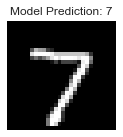

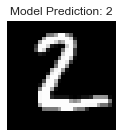

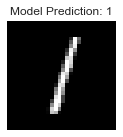

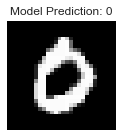

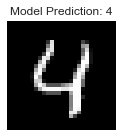

In [6]:
xtuple, ytuple = get_nist_data(mst=True,
                  validation=True,
                  norm_divisor=255.0,
                  label_to_categorical=True,
                  num_classes=10)

_, _, x_test = xtuple
_, _, y_test = ytuple

# let's use the first 10 as demo
demo_sample_number = 10
demobatch = x_test[:demo_sample_number]
demobatchlabels = y_test[:demo_sample_number]

print("x_test shape: ", demobatch.shape)
print("y_test shape: ", demobatchlabels.shape)

# we'll predict on this first 10 images
logits =  new_session.run([y_logits_op], feed_dict={input_op: demobatch})[0]
predictions = logits.argmax(axis=1)

for i in range(5):
    plot_single_img(demobatch[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]))

# Let's compute a variety of saliency masks for the test inputs

In [7]:
# setup constructor and methods
saliency_dict, n_selector = get_saliency_constructors(new_session.graph,
                                                      new_session,
                                                      y_logits_op[0],
                                                      input_op,
                                                      gradcam=True,
                                                      conv_layer_gradcam=h2convact)

saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                    'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                    'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                    'Integrated\nGradients': saliency_dict['ig'].GetMask,
                    'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                    'GradCAM': saliency_dict['gc'].GetMask}

list_of_masks = [] # save aggregate masks here.
for i, current_image in enumerate(demobatch):
    print("On image {}".format(i))
    baseline = np.zeros(current_image.shape)
    imglogits = new_session.run([y_logits_op],
                                    feed_dict={input_op: np.expand_dims(current_image, 0)})[0]
    
    prediction_class = imglogits.argmax() # this the output to explain.
    gen_feed_dict = {n_selector: prediction_class}
    
    # set up params for each saliency method
    saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                       'SmoothGrad': {"feed_dict": gen_feed_dict,
                                      "stdev_spread":0.15,
                                      "nsamples":50,
                                      "magnitude":False},
                       'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                       'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                 "x_steps":50,
                                                 "x_baseline":baseline},
                       'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                          "x_steps":50,
                                          "stdev_spread": 0.15,
                                          "x_baseline":baseline,
                                          "magnitude":False},
                       'GradCAM':{"feed_dict": gen_feed_dict,
                                  "three_dims": False}
                      }    
    
    output_masks = {}
    for key in saliency_methods:
        # print("On {}".format(key))
        params = saliency_params[key]
        output_masks[key] = saliency_methods[key](current_image,**params)
            
    # compute some other methods
    # input-gradient and guided-gradcam
    output_masks["Input-Grad"] = output_masks['Gradient']*current_image
    output_masks["GBP-GC"] = output_masks['Guided\nBackProp']*output_masks['GradCAM']
    list_of_masks.append(output_masks)

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On image 0
On image 1
On image 2
On image 3
On image 4
On image 5
On image 6
On image 7
On image 8
On image 9


# Let's process and visualize these masks

In [8]:
# We are now doing normalization of the different attributions
# normalize by absolute values
list_of_masks_abs_norm = []

# normalize but keep the signs
list_of_masks_no_abs_norm = []

for i, img_dict in enumerate(list_of_masks):
    new_dict_abs_norm = {}
    new_dict_no_abs_norm = {}
    for key in img_dict:
        mask = img_dict[key]
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        new_dict_abs_norm[key] = mask_abs_norm
        new_dict_no_abs_norm[key] = mask_no_abs_norm
        
    list_of_masks_abs_norm.append(new_dict_abs_norm)
    list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
    
# combine all the images to be plotted into one long list
# format is [(input, mask1, mask2, etc)]
mask_order = ["Gradient", "SmoothGrad", "Guided\nBackProp",\
              "Integrated\nGradients", "Input-Grad", "IG\nSmoothGrad", "GradCAM", "GBP-GC"]
master_mask_list_abs_norm = []
master_mask_list_no_abs_norm = []
for i, (img_dict_abs_norm, img_dict_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                  list_of_masks_no_abs_norm)):
    # first append original image
    og_img = demobatch[i]
    master_mask_list_abs_norm.append(og_img)
    master_mask_list_no_abs_norm.append(og_img)
    
    # loop through dicts to append each mask type
    for mask_type in mask_order:
        master_mask_list_abs_norm.append(img_dict_abs_norm[mask_type])
        master_mask_list_no_abs_norm.append(img_dict_no_abs_norm[mask_type])

# Grayscale Visualization (Positive relevance only)

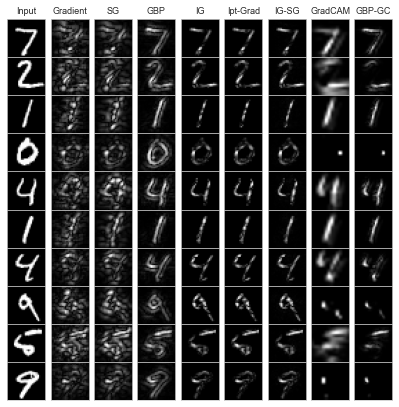

In [9]:
ncols = len(mask_order) + 1
nrows = len(list_of_masks_abs_norm)

    
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Input", "Gradient", "SG", "GBP",\
          "IG", "Ipt-Grad", "IG-SG", "GradCAM", "GBP-GC"]
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%ncols==0):
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=0.0,
                      vmax=1.0,
                      cmap='gray')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=0.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < ncols:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

# Cascading randomization of layers 

In [12]:
layer_names = ["softmax_linear", "fc1", "hidden2", "hidden1"] # model layer names from src/train_cnn_models.py

master_cascading_randomization_dictionary = {} # key will be layer name.
# for l_randomize_index, layer_name in enumerate(layer_randomization_order):
for ind, layer_name in enumerate(layer_names):
    # path to metapath and checkpoint path
    print("On layer {}".format(layer_name))
    # reintialize the required layer
    graphinfo = load_graph_and_randomize_layer(
                                   CHECKPOINTPATH,
                                   METAPATH,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=True,
                                   layertorandomize=layer_names[:ind+1])
    current_graph = graphinfo[0]
    new_session = graphinfo[1]
    y_logits_op = graphinfo[2]
    input_op = graphinfo[3]
    h2convact = graphinfo[4]
    list_of_ops_training = graphinfo[5]
    randparamlist = graphinfo[6]
    
    # set up saliency dict and n_selector.
    saliency_dict, n_selector = get_saliency_constructors(new_session.graph,
                                                      new_session,
                                                      y_logits_op[0],
                                                      input_op,
                                                      gradcam=True,
                                                      conv_layer_gradcam=h2convact)
    
    saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                        'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                        'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                        'Integrated\nGradients': saliency_dict['ig'].GetMask,
                        'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                        'GradCAM': saliency_dict['gc'].GetMask}
    
    list_of_random_mask_per_layer = []
    for i, current_image in enumerate(demobatch):
        # print(i)
        baseline = np.zeros(current_image.shape)
        imglogits = new_session.run([y_logits_op],
                                        feed_dict={input_op: np.expand_dims(current_image, 0)})[0]

        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
        saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                           'SmoothGrad': {"feed_dict": gen_feed_dict,
                                          "stdev_spread":0.15,
                                          "nsamples":50,
                                          "magnitude":False},
                           'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                           'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                     "x_steps":50,
                                                     "x_baseline":baseline},
                           'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                              "x_steps":50,
                                              "stdev_spread": 0.15,
                                              "x_baseline":baseline,
                                              "magnitude":False},
                           'GradCAM':{"feed_dict": gen_feed_dict,
                                      "three_dims": False}
                          }    

        output_masks = {}
        for key in saliency_methods:
            # print("On {}".format(key))
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)

        # compute some other methods
        # input-gradient and guided-gradcam
        output_masks["Input-Grad"] = output_masks['Gradient']*current_image
        output_masks["GBP-GC"] = output_masks['Guided\nBackProp']*output_masks['GradCAM']
        list_of_random_mask_per_layer.append(output_masks)
        
    # now add the list of random masks to the dictionary
    master_cascading_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

On layer softmax_linear
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
Instructions for updating:
Use `tf.variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On layer fc1
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On layer hidden2
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On layer hidden1
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


# Mask PostProcessing

In [13]:
master_cascading_randomization_dictionary_abs_norm = {}
master_cascading_randomization_dictionary_no_abs_norm = {}

for layer in master_cascading_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
    master_cascading_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_cascading_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm

In [14]:
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_no_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_abs_norm[key][i])

# Let's plot cascading results

**Change the variable index_to_input_to_plot to visualize the other inputs**

We will only plot one input here. 

In [15]:
cascading_master_plotting_list_abs_norm = []
cascading_master_plotting_list_no_abs_norm = []

index_to_input_to_plot = 0 # this must be less than the len of demo_batch
assert index_to_input_to_plot < demobatch.shape[0]


# Order that we want to show the masks in.
mask_order = ["Gradient", "SmoothGrad", "Guided\nBackProp",\
              "Integrated\nGradients", "Input-Grad", "IG\nSmoothGrad",\
              "GradCAM", "GBP-GC"]
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]

for method in mask_order:
    # first insert normal saliency method
    normal_mask_abs_norm = list_of_masks_abs_norm[index_to_input_to_plot][method]
    normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_to_input_to_plot][method]
    cascading_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
    cascading_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
    for layer in layer_order:
        mask_abs_norm =  master_cascading_randomization_dictionary_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_abs_norm.append(mask_abs_norm)
        
        mask_no_abs_norm =  master_cascading_randomization_dictionary_no_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)
        

print(len(cascading_master_plotting_list_abs_norm))
print(len(cascading_master_plotting_list_no_abs_norm))

40
40


# Rank Correlation Comparison Plots

Now let's compute rank correlation between maps derived from (partially) randomized models and those from the pre-trained model

In [18]:
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]
methods_list = list(master_cascading_randomization_dictionary_abs_norm['hidden1'][0].keys())
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}

for layer in layer_order:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []
        
for layer in master_cascading_randomization_dictionary_abs_norm:
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = list_of_masks_abs_norm[i][method]
            normal_mask_no_abs_norm = list_of_masks_no_abs_norm[i][method]
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm =\
                master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs)

In [19]:
rk_mean_dictionary = {}
rk_std_dictionary = {}
for key in rank_correlation_dictionary_abs_norm:
    rk_mean_dictionary[key] = {}
    rk_std_dictionary[key] = {}
    for key2 in rank_correlation_dictionary_abs_norm[key]:
        rk_mean_dictionary[key][key2] = np.mean(rank_correlation_dictionary_abs_norm[key][key2])
        rk_std_dictionary[key][key2] = np.std(rank_correlation_dictionary_abs_norm[key][key2])

In [20]:
test_df = pd.DataFrame(rk_mean_dictionary)
test_df2 = pd.DataFrame(rk_std_dictionary)

# include no randomization
test_df["orig"] = [1.0]*test_df.shape[0]
test_df2["orig"] = [1.0]*test_df2.shape[0]

# switch order of the columns
layer_order = ["orig", "softmax_linear", "fc1", "hidden2", "hidden1"]
to_reverse = False
if to_reverse:
    layer_order = list(reversed(layer_order))
test_df = test_df.reindex(columns=layer_order)
test_df2 = test_df2.reindex(columns=layer_order)

# Rank Correlation Plots with Positive Relevance Only masks

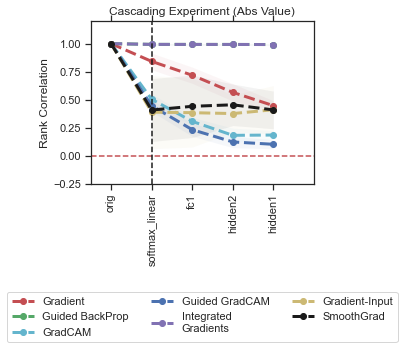

In [23]:
sns.set(style="ticks")
plt.figure(figsize=(4,3))

gcam = test_df.iloc[[1]].values[0]
grad = test_df.iloc[[2]].values[0]
gbp = test_df.iloc[[3]].values[0]
ig = test_df.iloc[[6]].values[0]
ggcam = test_df.iloc[[0]].values[0]
inputgrad = test_df.iloc[[5]].values[0]
sgrad = test_df.iloc[[7]].values[0]

gcam_std = test_df2.iloc[[1]].values[0]
grad_std = test_df2.iloc[[2]].values[0]
gbp_std = test_df2.iloc[[3]].values[0]
ig_std = test_df2.iloc[[6]].values[0]
ggcam_std = test_df2.iloc[[0]].values[0]
inputgrad_std = test_df2.iloc[[5]].values[0]
sgrad_std = test_df2.iloc[[7]].values[0]


x = [i+1 for i in range(len(gcam))]
plt.plot(x, grad, 'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x[1:], grad[1:]-grad_std[1:], grad[1:]+grad_std[1:], facecolor='r', alpha=0.05)

plt.plot(x, gbp, 'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x[1:], gbp[1:]-gbp_std[1:], gbp[1:]+gbp_std[1:], facecolor='g', alpha=0.05)

plt.plot(x, gcam, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x[1:], gcam[1:]-gcam_std[1:], gcam[1:]+gcam_std[1:], facecolor='c', alpha=0.05)

plt.plot(x, ggcam, 'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x[1:], ggcam[1:]-ggcam_std[1:], ggcam[1:]+ggcam_std[1:], facecolor='b', alpha=0.05)

plt.plot(x, ig, 'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x[1:], ig[1:]-ig_std[1:], ig[1:]+ig_std[1:], facecolor='m', alpha=0.05)

plt.plot(x, inputgrad, 'yo-', linestyle='--', lw=3, label='Gradient-Input')
plt.fill_between(x[1:], inputgrad[1:]-inputgrad_std[1:], inputgrad[1:]+inputgrad_std[1:], facecolor='y', alpha=0.05)

plt.plot(x, sgrad, 'ko-', lw=3, linestyle='--', label='SmoothGrad')
plt.fill_between(x[1:], sgrad[1:]-sgrad_std[1:], sgrad[1:]+sgrad_std[1:], facecolor='k', alpha=0.05)

plt.xticks(x, layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
plt.xlim([0.5, 6])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (Abs Value)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.tick_params(axis='x', which='both', top='off')
plt.show()

# Rank Correlation Plot with Signed Masks

In [24]:
rk_mean_dictionary_no_abs = {}
rk_std_dictionary_no_abs = {}
for key in rank_correlation_dictionary_no_abs_norm:
    rk_mean_dictionary_no_abs[key] = {}
    rk_std_dictionary_no_abs[key] = {}
    for key2 in rank_correlation_dictionary_no_abs_norm[key]:
        rk_mean_dictionary_no_abs[key][key2] = np.mean(rank_correlation_dictionary_no_abs_norm[key][key2])
        rk_std_dictionary_no_abs[key][key2] = np.std(rank_correlation_dictionary_no_abs_norm[key][key2])
        

test_df3 = pd.DataFrame(rk_mean_dictionary_no_abs)
test_df4 = pd.DataFrame(rk_std_dictionary_no_abs)

# include no randomization
test_df3["orig"] = [1.0]*test_df3.shape[0]
test_df4["orig"] = [1.0]*test_df4.shape[0]

# switch order of the columns
layer_order = ["orig", "softmax_linear", "fc1", "hidden2", "hidden1"]
to_reverse = False
if to_reverse:
    layer_order = list(reversed(layer_order))
test_df3 = test_df3.reindex(columns=layer_order)
test_df4 = test_df4.reindex(columns=layer_order)

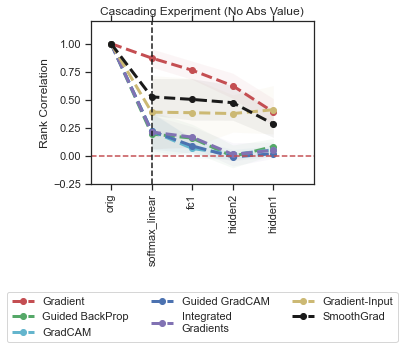

In [25]:
sns.set(style="ticks")
plt.figure(figsize=(4,3))

gcam = test_df3.iloc[[1]].values[0]
grad = test_df3.iloc[[2]].values[0]
gbp = test_df3.iloc[[3]].values[0]
ig = test_df3.iloc[[6]].values[0]
ggcam = test_df3.iloc[[0]].values[0]
inputgrad = test_df3.iloc[[5]].values[0]
sgrad = test_df3.iloc[[7]].values[0]

gcam_std = test_df4.iloc[[1]].values[0]
grad_std = test_df4.iloc[[2]].values[0]
gbp_std = test_df4.iloc[[3]].values[0]
ig_std = test_df4.iloc[[6]].values[0]
ggcam_std = test_df4.iloc[[0]].values[0]
inputgrad_std = test_df2.iloc[[5]].values[0]
sgrad_std = test_df4.iloc[[7]].values[0]


x = [i+1 for i in range(len(gcam))]
plt.plot(x, grad, 'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x[1:], grad[1:]-grad_std[1:], grad[1:]+grad_std[1:], facecolor='r', alpha=0.05)

plt.plot(x, gbp, 'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x[1:], gbp[1:]-gbp_std[1:], gbp[1:]+gbp_std[1:], facecolor='g', alpha=0.05)

plt.plot(x, gcam, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x[1:], gcam[1:]-gcam_std[1:], gcam[1:]+gcam_std[1:], facecolor='c', alpha=0.05)

plt.plot(x, ggcam, 'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x[1:], ggcam[1:]-ggcam_std[1:], ggcam[1:]+ggcam_std[1:], facecolor='b', alpha=0.05)

plt.plot(x, ig, 'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x[1:], ig[1:]-ig_std[1:], ig[1:]+ig_std[1:], facecolor='m', alpha=0.05)

plt.plot(x, inputgrad, 'yo-', linestyle='--', lw=3, label='Gradient-Input')
plt.fill_between(x[1:], inputgrad[1:]-inputgrad_std[1:], inputgrad[1:]+inputgrad_std[1:], facecolor='y', alpha=0.05)

plt.plot(x, sgrad, 'ko-', lw=3, linestyle='--', label='SmoothGrad')
plt.fill_between(x[1:], sgrad[1:]-sgrad_std[1:], sgrad[1:]+sgrad_std[1:], facecolor='k', alpha=0.05)

plt.xticks(x, layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
plt.xlim([0.5, 6])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (No Abs Value)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.tick_params(axis='x', which='both', top='off')
plt.show()